### EXP: Beta1 QC rating 

- **Aim:** First attempt of assesing quality control (QC) of brain registration on the Zooniverse platform. Raters are some of zooniverse users who agreed to test new projects and give feedback ( ref: https://www.zooniverse.org/projects/simexp/brain-match ).

- **Exp:** 
    - We choose 100 anatomical brain images (?? OK, ?? Maybe and ?? Fail)   preprocced with NIAK pipelines from ADHD200 datsets.
    - We asked raters on the Zooniverse platform to QC images based on the tutorial and the rated sample images.

In [196]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [197]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [198]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [199]:
# Read raw table
classifications = pd.read_csv('../data/rating/brain-match-classifications-12-10-2018.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [200]:
# List all workflows 
classifications.workflow_version.unique()

array([12.12, 12.13,  1.2 , 12.2 , 14.28,  1.9 , 14.3 ,  1.12,  1.1 ,
       16.1 , 16.2 ,  1.3 , 18.2 ,  2.3 ,  1.27,  2.6 ,  2.7 ,  2.12])

In [201]:
# Filter out only specific workflow
ratings = classifications.loc[classifications['workflow_name'].isin(['Spot anatomical differences']) &
                             classifications['workflow_version'].isin(['14.3'])]
ratings.count()

classification_id    1365
user_name            1365
user_id               988
user_ip              1365
workflow_id          1365
workflow_name        1365
workflow_version     1365
created_at           1365
gold_standard           0
expert                  0
metadata             1365
annotations          1365
subject_data         1365
subject_ids          1365
dtype: int64

In [202]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[1]['value']) for q in ratings.annotations]
# extract rating count
ratings.loc[:,"rating"] = [ q[0]['value'] for q in ratings.annotations]
# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids[ind])]['subject_ID'] for ind,row in ratings.iterrows()]
# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids[ind])]['images'] for ind,row in ratings.iterrows()]

In [203]:
# How many rating per user
user_count = ratings.user_name.value_counts()
user_count

EcceruElme                            58
KazzaY                                46
Dennis21                              41
asko_oksa                             30
not-logged-in-064781f2567efce122db    28
Liisika                               23
cyerby                                21
WEBs_in_space                         19
Chris5420                             19
CDawgUnleashed                        19
Kroth                                 17
MishySee                              17
Lostasagoose                          16
not-logged-in-73c860b38b85defd0805    16
nhaberman                             16
jschott5                              16
not-logged-in-68dd3f93fae58eff8a53    15
ReggieMcintosh                        14
not-logged-in-ded933a4b119ccaefd6a    13
sapphira80                            13
141Dial34                             13
not-logged-in-bf3e439ee2f80b8bef3a    13
OldWoodchuck                          12
DFK1951                               12
Manny936        

In [204]:
#select only users that have rated a certain ammount of images 
list_user = user_count.index
list_user = list_user[user_count.values>=10]
user_count[list_user]

EcceruElme                            58
KazzaY                                46
Dennis21                              41
asko_oksa                             30
not-logged-in-064781f2567efce122db    28
Liisika                               23
cyerby                                21
WEBs_in_space                         19
Chris5420                             19
CDawgUnleashed                        19
Kroth                                 17
MishySee                              17
Lostasagoose                          16
not-logged-in-73c860b38b85defd0805    16
nhaberman                             16
jschott5                              16
not-logged-in-68dd3f93fae58eff8a53    15
ReggieMcintosh                        14
not-logged-in-ded933a4b119ccaefd6a    13
sapphira80                            13
141Dial34                             13
not-logged-in-bf3e439ee2f80b8bef3a    13
OldWoodchuck                          12
DFK1951                               12
Manny936        

In [205]:
# remove users with less rating then the selected threshold
ratings = ratings[ratings.user_name.isin(list_user)]
ratings.count()

classification_id    651
user_name            651
user_id              523
user_ip              651
workflow_id          651
workflow_name        651
workflow_version     651
created_at           651
gold_standard          0
expert                 0
metadata             651
annotations          651
subject_data         651
subject_ids          651
n_tagging            651
rating               651
ID                   651
imgnm                651
dtype: int64

In [206]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

not-logged-in-bff2d9caebce8b749a95 have 2 duplicated ratings
nhaberman have 2 duplicated ratings
not-logged-in-bf3e439ee2f80b8bef3a have 6 duplicated ratings
not-logged-in-064781f2567efce122db have 8 duplicated ratings
kryswolf have 2 duplicated ratings
sapphira80 have 3 duplicated ratings
Liisika have 3 duplicated ratings
asko_oksa have 20 duplicated ratings
ReggieMcintosh have 3 duplicated ratings
not-logged-in-ded933a4b119ccaefd6a have 3 duplicated ratings
Manny936 have 1 duplicated ratings
cyerby have 1 duplicated ratings
not-logged-in-3085bc192f4ce6d18fcf have 1 duplicated ratings
Dennis21 have 21 duplicated ratings
Total number of duplicated ratings  = 76


In [207]:
# Get the final rating numbers per subject
user_count = classi_unique.user_name.value_counts()
user_count

EcceruElme                            58
KazzaY                                46
Liisika                               20
Dennis21                              20
cyerby                                20
not-logged-in-064781f2567efce122db    20
WEBs_in_space                         19
CDawgUnleashed                        19
Chris5420                             19
Kroth                                 17
MishySee                              17
jschott5                              16
Lostasagoose                          16
not-logged-in-73c860b38b85defd0805    16
not-logged-in-68dd3f93fae58eff8a53    15
nhaberman                             14
141Dial34                             13
DFK1951                               12
Ptd                                   12
OldWoodchuck                          12
joncarruthers                         12
anne_vincent_64                       11
MBeeHH                                11
Manny936                              11
ReggieMcintosh  

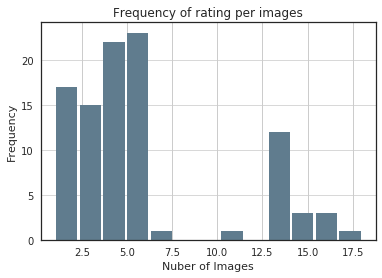

In [208]:
# plot rating per image distribution
image_count = classi_unique.subject_ids.value_counts()
image_count.plot.hist(grid=True,rwidth=0.9, bins=13,color='#607c8e')
plt.title('Frequency of rating per images')
plt.xlabel('Nuber of Images')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [209]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
df_ratings.head()

,ID,EcceruElme,KazzaY,Liisika,Dennis21,cyerby,not-logged-in-064781f2567efce122db,WEBs_in_space,CDawgUnleashed,Chris5420,...,kryswolf,not-logged-in-d7c66341cb26e8d5e6de,asko_oksa,not-logged-in-1bd8d63f5af2e4f1a57e,not-logged-in-3085bc192f4ce6d18fcf,Ros_Stannard,not-logged-in-bff2d9caebce8b749a95,Danielle_Gonalves,sapphira80,not-logged-in-bf3e439ee2f80b8bef3a
0,X0010031,Fail,OK,Fail,OK,Maybe,Fail,NaN,NaN,NaN,...,OK,NaN,OK,NaN,NaN,NaN,NaN,NaN,OK,NaN
1,X8432725,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,X0026022,Fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,X3809753,Fail,OK,Maybe,OK,OK,Maybe,NaN,NaN,Fail,...,NaN,OK,NaN,OK,OK,Maybe,NaN,NaN,NaN,NaN
4,X2136051,Fail,OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [210]:
# remove duplicates
df_ratings = df_ratings[~df_ratings.ID.duplicated()]

### Explore the concensus of rating between images

In [211]:
# Get ratings from images rated more tan N different rates 
n = 4 # Minimun number of ratings per image
stuff = np.array([[row.ID,
                   np.sum(row[1:].values=='Fail'),
                   np.sum(row[1:].values=='Maybe'),
                   np.sum(row[1:].values=='OK')]  
                  for ind, row in df_ratings.iterrows() if np.sum([np.sum(row[1:-1].values=='Fail'),
                                                                 np.sum(row[1:-1].values=='Maybe'),
                                                                 np.sum(row[1:-1].values=='OK')]) >= n])
df_score = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
df_score.head()

,ID,Fail,Maybe,OK
0,X0010031,6,1,6
1,X3809753,3,5,8
2,X0026002,2,1,1
3,X0010049,3,5,5
4,X2961243,2,2,1


In [212]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'max_value_NoExp'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'concensus_NoExp'] = max_rate
df_norm.head()

,ID,Fail,Maybe,OK,max_value_NoExp,concensus_NoExp
0,X0010031,0.461538,0.0769231,0.461538,0.461538,Fail
1,X3809753,0.1875,0.3125,0.5,0.500000,OK
2,X0026002,0.5,0.25,0.25,0.500000,Fail
3,X0010049,0.230769,0.384615,0.384615,0.384615,Maybe
4,X2961243,0.4,0.4,0.2,0.400000,Fail


In [213]:
# Save a copy of concensus ratings
df_ = df_norm[['ID','concensus_NoExp']].rename(columns={'concensus_NoExp':'Cons_B1'})
df_.to_csv('../data/rating/Beta1_zooniverse_rating.csv',index=False)

Text(0, 0.5, 'Concensus rating')

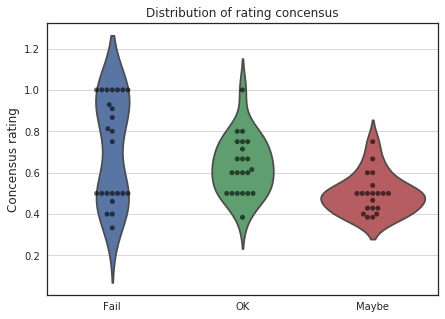

In [214]:
#Setting the figure with matplotlib
plt.figure(figsize=(7,5))
#plt.xticks(rotation=90)
plt.rcParams["axes.labelsize"] = 12
 
#Creating the desired plot
sns.violinplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
              inner=None #removes the inner bars inside the violins 
              )
 
sns.swarmplot(x='concensus_NoExp',y='max_value_NoExp',data=df_norm,
             color='k',#for making the points black
             alpha=0.6) #value of alpha will increase the transparency
 
#Title for the plot
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of rating concensus')
plt.xlabel('')
plt.ylabel('Concensus rating')

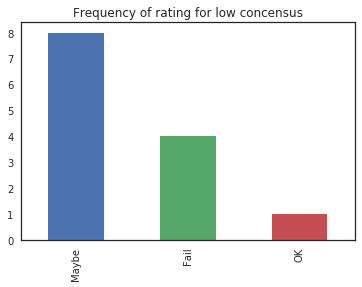

In [215]:
count_ = df_norm.concensus_NoExp[[0 <= row.max_value_NoExp < 0.5   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for low concensus')

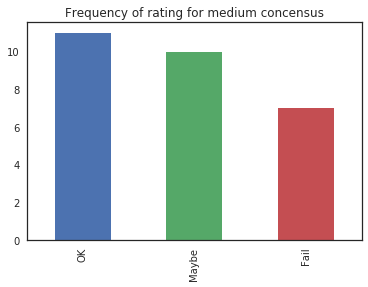

In [216]:
count_ = df_norm.concensus_NoExp[[0.5 <= row.max_value_NoExp < 0.65   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for medium concensus')

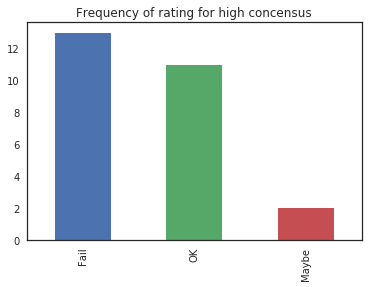

In [217]:
count_ = df_norm.concensus_NoExp[[0.6 < row.max_value_NoExp <= 1   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for high concensus')

### Merge Pilot2 and Beta1 rating and get Kappa score

In [218]:
pilot2 = pd.read_csv('../data/rating/Pilot2_internal_rating-PB_YB.csv')
pilot2.head()

,ID,PB,YB
0,X3160561,Maybe,Maybe
1,X3848511,Maybe,Maybe
2,X3163200,Maybe,OK
3,X2081148,Maybe,Maybe
4,X0021046,Fail,Fail


In [219]:
# Merge 
merge_ratings = pd.merge(pilot2,df_norm[['ID','concensus_NoExp']],on='ID',how='inner').apply(lambda x: x.str.strip() if x.dtype == "object" else x)
merge_ratings.rename(columns={'PB':'PB_P2','YB':'YB_P2','concensus_NoExp':'Beta1'},inplace=True)
merge_ratings.head()

,ID,PB_P2,YB_P2,Beta1
0,X3160561,Maybe,Maybe,Maybe
1,X3848511,Maybe,Maybe,Fail
2,X3163200,Maybe,OK,Fail
3,X2081148,Maybe,Maybe,Maybe
4,X0026039,OK,Maybe,OK


In [220]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
merge_ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)
merge_ratings.head()

,ID,PB_P2,YB_P2,Beta1
0,X3160561,2,2,2
1,X3848511,2,2,3
2,X3163200,2,1,3
3,X2081148,2,2,2
4,X0026039,1,2,1


In [221]:
%%R
suppressPackageStartupMessages(library(dplyr))
#install.packages("irr") 
library(irr)

In [222]:
# Percenteage of agrrement between raters with R package IRR
agree_ = merge_ratings[['PB_P2','YB_P2','Beta1']]
%Rpush agree_
agree_n = %R agree(agree_)
print(agree_n)

 Percentage agreement (Tolerance=0)

 Subjects = 32 
   Raters = 3 
  %-agree = 43.8 



In [224]:
# FDR correction
from statsmodels.sandbox.stats import multicomp as smi

def fdr_transf(mat,log10 = False):
    '''compute fdr of a given matrix'''
    
    row = mat.shape[0]
    col = mat.shape[1]
    flatt = mat.flatten()
    fdr_2d = smi.multipletests(flatt, alpha=0.05, method='fdr_bh')[1]
    if log10 == True:
        fdr_2d = [-np.log10(ii) if ii != 0 else 50 for ii in fdr_2d  ]
    fdr_3d = np.reshape(fdr_2d,(row,col))
    return fdr_3d

In [225]:
# Kappa calculation
def kappa_score(k_df,log10 = False):
    '''compute Kappa between diferent raters organized in dataframe'''
    k_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    p_store = np.zeros((len(k_df.columns), len(k_df.columns)))
    %Rpush k_df
    for user1_id, user1 in enumerate(k_df.columns):
        for user2_id, user2 in enumerate(k_df.columns):
            weight = np.unique(kappa_df[[user1,user2]])
            %Rpush user1_id user1 user2_id user2 weight
            kappaR =  %R kappa2(k_df[,c(user1,user2)],weight)
            
            # store the kappa
            k_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][4]
            p_store[user1_id, user2_id] = [kappaR[x][0] for x in range(np.shape(kappaR)[0])][-1]
            
    # FDR Correction       
    p_store = fdr_transf(p_store,log10)
    return k_store, p_store

In [226]:
# Get Kappa score out of all different combination of ratings
kappa_df  = merge_ratings[['PB_P2','YB_P2','Beta1']]
kappa_store, Pval_store = kappa_score(kappa_df)
mean_kap = np.mean(kappa_store[np.triu_indices(len(kappa_store),k=1)])
std_kap = np.std(kappa_store[np.triu_indices(len(kappa_store),k=1)])
print('Mean Kappa : {0:.2f} , std : {1:.2f}\n'.format(mean_kap, std_kap))

#calculte the over all kappa values of all ratings
%Rpush kappa_df
fleiss_kappa = %R kappam.fleiss(kappa_df,c(0,1,2))
print(fleiss_kappa)

Mean Kappa : 0.45 , std : 0.13

 Fleiss' Kappa for m Raters

 Subjects = 32 
   Raters = 3 
    Kappa = 0.386 

        z = 5.34 
  p-value = 9.42e-08 



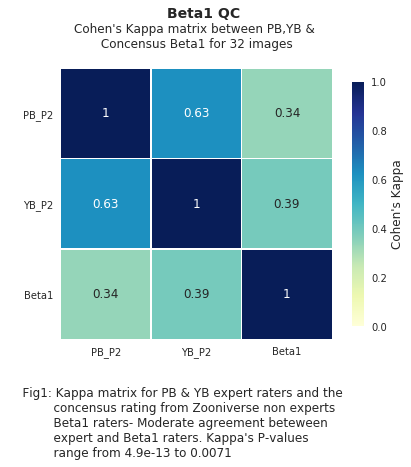

In [244]:
# Plot kappa matrix
kappa_out = pd.DataFrame(kappa_store, 
                         index=kappa_df.columns.get_values(),
                         columns=kappa_df.columns.get_values())


# Set up the matplotlib figure
f, axes = plt.subplots(figsize = (7,5))
f.subplots_adjust(hspace= .8)

f.suptitle('Beta1 QC',x=0.49,y=1.05, fontsize=14, fontweight='bold')
# Draw kappa heat map
sns.heatmap(kappa_out,vmin=0,vmax=1,cmap="YlGnBu",
            square=True,
            annot=True,
            linewidths=.5, 
            cbar_kws={"shrink": .9,"label": "Cohen's Kappa"}, 
            ax=axes)
axes.set_yticks([x+0.5 for x in range(len(kappa_df.columns))])
axes.set_yticklabels(kappa_df.columns,rotation=0)
axes.set_title("Cohen's Kappa matrix between PB,YB & \n Concensus Beta1 for {} images ".format(len(merge_ratings)),
               pad=20,fontsize=12)

# Caption
pval = np.unique(Pval_store)[-1]
txt = '''
    Fig1: Kappa matrix for PB & YB expert raters and the 
            concensus rating from Zooniverse non experts 
            Beta1 raters- Moderate agreement beteween  
            expert and Beta1 raters. Kappa's P-values 
            range from {:.2g} to {:.2g} '''.format(Pval_store.min(), Pval_store.max())
f.text(.1,-0.2,txt,fontsize=12)
# Save figure
f.savefig('../reports/figures/Beta1_qc.svg')

In [236]:
from IPython.display import Image
Image(url= "https://i.stack.imgur.com/kYNd6.png" ,width=600, height=600)

### Report tagging from Beta1 raters

In [237]:
# output markings from classifications
clist=[]
for index, c in classi_unique.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[1]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'1.5','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out_tag = pd.DataFrame(clist)[col_order]
out_tag.user_name.replace({'simexp':'PB','Yassinebha':'YB'},inplace=True)
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X0021010,Spot anatomical differences,joncarruthers,OK,NaN,NaN,NaN,0,summary_X0021010_anat2template.gif,1
1,X3848511,Spot anatomical differences,joncarruthers,Fail,333.5,102.0,1.5,2,summary_X3848511_anat2template.gif,0
2,X3848511,Spot anatomical differences,joncarruthers,Fail,302.5,106.0,1.5,2,summary_X3848511_anat2template.gif,0
3,X2054998,Spot anatomical differences,joncarruthers,Maybe,220.5,184.0,1.5,2,summary_X2054998_anat2template.gif,0
4,X2054998,Spot anatomical differences,joncarruthers,Maybe,188.5,184.0,1.5,2,summary_X2054998_anat2template.gif,0


In [238]:
# Extract unique IDs for each image
ids_imgnm = np.reshape([out_tag.ID.unique(),out_tag.imgnm.unique()],(2,np.shape(out_tag.ID.unique())[0]))
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])
df_ids_imgnm.head()

,ID,imgnm
0,X0010003,summary_X0010003_anat2template.gif
1,X0010007,summary_X0010007_anat2template.gif
2,X0010009,summary_X0010009_anat2template.gif
3,X0010013,summary_X0010013_anat2template.gif
4,X0010029,summary_X0010029_anat2template.gif


In [239]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap , ListedColormap
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)


coll,a=_cmap_from_image_path('../data/Misc/custom_ColBar.png')
#invert color map
coll_r = ListedColormap(coll[::-1])

In [240]:
# set color different for each rater
list_tagger = out_tag.user_name.unique()
colors_tagger = sns.color_palette("Set2", len(list_tagger))

### Plot heat map for all tagging

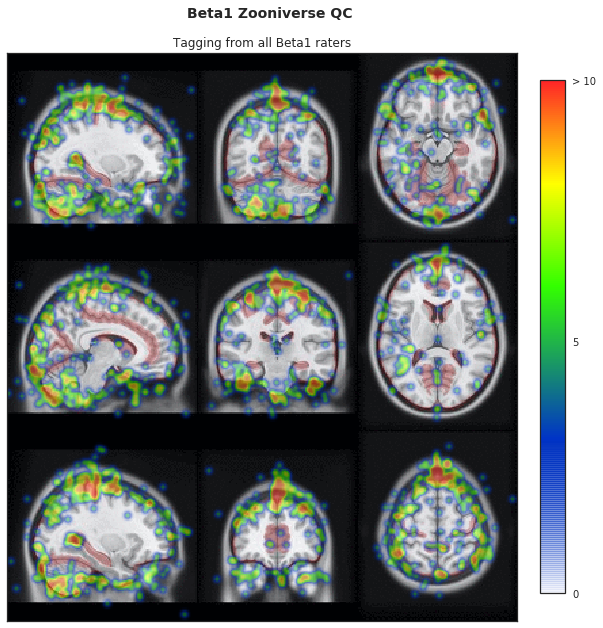

In [243]:
from heatmappy import Heatmapper
from PIL import Image

patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row.x,row.y) for ind,row in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Beta1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v1.png')
axes.set_title('Tagging from all Beta1 raters')

heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=10,
                        point_strength = 0.5,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patches, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '5', '> 10'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Beta1_qc_heatmap_tags.svg')